In [ ]:
!pip install -U accelerate transformers
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 128.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.0
    Uninstalling accelerate-1.10.0:
      Successfully uninstalled accelerate-1.10.0


In [ ]:
# ==== Colab: Upload zips -> sample <2001 -> save mdna_sample -> download zip ====
import io
import os
import re
import random
import shutil
import zipfile
import tempfile
from collections import Counter

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------
# Config you can tweak
# -----------------------
MAX_PER_CLASS = 200
YEAR_CUTOFF = 2006        # keep strictly < 2001 (i.e., up to 2000)
RANDOM_SEED = 42
CLASSES = ("fraud", "non_fraud")
OUTPUT_DIR = "mdna_sample"

# Filename pattern: capture a 4-digit year that is preceded by an underscore, anywhere.
# Examples matched: "5272_2000.txt", "acme_1998_v2.txt", "abc_1975-anything.TXT"
YEAR_RE = re.compile(r"_(19\d{2}|20\d{2})(?:\D|$)", re.IGNORECASE)

def parse_year_from_filename(name):
    m = YEAR_RE.search(name)     # <-- search, not match
    if not m:
        return None
    return int(m.group(1))

def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

def infer_class_from_path(path_lower):
    # zip internals use forward slashes
    if "/non-fraud/" in path_lower or "/non_fraud/" in path_lower or "/nonfraud/" in path_lower:
        return "non_fraud"
    if "/fraud/" in path_lower:
        return "fraud"
    return None

def infer_class_from_zipname(zip_basename_lower):
    if "non-fraud" in zip_basename_lower or "non_fraud" in zip_basename_lower or "nonfraud" in zip_basename_lower:
        return "non_fraud"
    if "fraud" in zip_basename_lower:
        return "fraud"
    return None

def collect_candidates_from_zip(zippath, tmp_extract_root):
    """
    Extract zip to a dedicated folder and collect eligible files per class.
    Returns: { 'fraud': [abs_paths...], 'non_fraud': [...] }
    """
    buckets = {c: [] for c in CLASSES}
    base_name = os.path.splitext(os.path.basename(zippath))[0]
    extract_here = os.path.join(tmp_extract_root, base_name)
    ensure_dir(extract_here)

    with zipfile.ZipFile(zippath, "r") as zf:
        zf.extractall(extract_here)

    # Fallback class from the zip filename (handles zips like 'Fraud_MDA-...zip')
    zip_class_hint = infer_class_from_zipname(os.path.basename(zippath).lower())

    for root, _, files_in_dir in os.walk(extract_here):
        root_lower = root.lower()
        # Prefer internal path hint; else use zip name hint
        cls_hint = infer_class_from_path(root_lower) or zip_class_hint

        for fn in files_in_dir:
            if not fn.lower().endswith(".txt"):
                continue
            year = parse_year_from_filename(fn)
            if year is None or year >= YEAR_CUTOFF:
                continue

            full = os.path.join(root, fn)
            # Light read to ensure file is accessible
            try:
                with io.open(full, "r", encoding="utf-8", errors="ignore") as f:
                    _ = f.read(512)
            except Exception:
                continue

            if cls_hint in buckets:
                buckets[cls_hint].append(full)
            # If we still can't infer class, we skip (we only want labeled classes)

    return buckets

def sample_and_copy(files, dst_dir):
    random.seed(RANDOM_SEED)
    if len(files) > MAX_PER_CLASS:
        files = random.sample(files, MAX_PER_CLASS)

    ensure_dir(dst_dir)
    used = set()
    copied = 0
    for src in files:
        name = os.path.basename(src)
        dest = os.path.join(dst_dir, name)
        # Avoid collisions
        if name in used or os.path.exists(dest):
            stem, ext = os.path.splitext(name)
            i = 1
            while True:
                alt = f"{stem}__dup{i}{ext}"
                dest = os.path.join(dst_dir, alt)
                if not os.path.exists(dest):
                    name = alt
                    break
                i += 1
        used.add(name)
        shutil.copy2(src, dest)
        copied += 1
    return copied

def by_year_counts(folder):
    """Return Counter of years for files in folder based on filename."""
    cnt = Counter()
    if not os.path.isdir(folder):
        return cnt
    for fn in os.listdir(folder):
        y = parse_year_from_filename(fn)
        if y is not None:
            cnt[y] += 1
    return cnt

def zip_dir(dir_path, zip_path):
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files_in_dir in os.walk(dir_path):
            for fn in files_in_dir:
                abs_p = os.path.join(root, fn)
                rel_p = os.path.relpath(abs_p, dir_path)
                zf.write(abs_p, rel_p)

# =======================
# Step 1: Upload ZIPs
# =======================
uploaded_paths = []
if IN_COLAB:
    print("📤 Upload one or more ZIP files...")
    uploaded = files.upload()  # user selects zips from laptop
    for name, data in uploaded.items():
        with open(name, "wb") as f:
            f.write(data)
        uploaded_paths.append(os.path.abspath(name))
    if not uploaded_paths:
        raise SystemExit("No files uploaded.")
else:
    raise SystemExit("This notebook cell is intended for Google Colab (files.upload).")

# =======================
# Step 2: Process ZIPs
# =======================
# Clean any previous output
if os.path.isdir(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
ensure_dir(os.path.join(OUTPUT_DIR, "fraud"))
ensure_dir(os.path.join(OUTPUT_DIR, "non_fraud"))

totals = {c: [] for c in CLASSES}

with tempfile.TemporaryDirectory() as tmp_root:
    for zp in uploaded_paths:
        try:
            buckets = collect_candidates_from_zip(zp, tmp_root)
        except Exception as e:
            print(f"[WARN] Failed to handle {os.path.basename(zp)}: {e}")
            continue
        for c in CLASSES:
            totals[c].extend(buckets.get(c, []))

    # Deduplicate (within this run) and sample+copy
    for c in CLASSES:
        unique_files = list(dict.fromkeys(totals[c]))  # preserve order, remove dups
        copied = sample_and_copy(unique_files, os.path.join(OUTPUT_DIR, c))
        print(f"{c:>10}: eligible={len(unique_files):4d}, copied={copied:3d} (max {MAX_PER_CLASS})")

print("\n✅ Done sampling. Saved to:", os.path.abspath(OUTPUT_DIR))

# =======================
# Step 3: By-year counts
# =======================
for c in CLASSES:
    cnt = by_year_counts(os.path.join(OUTPUT_DIR, c))
    if cnt:
        print(f"\n📅 By-year counts for '{c}' (in sample):")
        for y in sorted(cnt):
            print(f"  {y}: {cnt[y]}")
    else:
        print(f"\n📅 By-year counts for '{c}': (no files)")

# =======================
# Step 4: Downloadable ZIP
# =======================
zip_name = "mdna_sample.zip"
zip_dir(OUTPUT_DIR, zip_name)
print("\n📦 Created archive:", os.path.abspath(zip_name))

if IN_COLAB:
    files.download(zip_name)


📤 Upload one or more ZIP files...


Saving Fraud_MDA_cleaned.zip to Fraud_MDA_cleaned.zip
Saving Non-fraud_MDA_cleaned.zip to Non-fraud_MDA_cleaned.zip
     fraud: eligible= 276, copied=200 (max 200)
 non_fraud: eligible= 138, copied=138 (max 200)

✅ Done sampling. Saved to: /content/mdna_sample

📅 By-year counts for 'fraud' (in sample):
  1995: 1
  1996: 2
  1997: 6
  1998: 6
  1999: 8
  2000: 16
  2001: 29
  2002: 39
  2003: 41
  2004: 23
  2005: 29

📅 By-year counts for 'non_fraud' (in sample):
  1995: 2
  1996: 4
  1998: 4
  1999: 8
  2000: 4
  2002: 20
  2003: 22
  2004: 36
  2005: 38

📦 Created archive: /content/mdna_sample.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Build mdna_samples.json from mdna_sample.zip ===
import os, io, json, zipfile, shutil

ZIP_NAME = "mdna_sample.zip"         # <-- must exist in current working dir
EXTRACT_DIR = "./mdna_sample_extracted"
OUTPUT_JSON = "mdna_samples.json"

# 1) Ensure the zip exists (if not, let you upload it)
if not os.path.isfile(ZIP_NAME):
    try:
        from google.colab import files
        print(f"⚠️ {ZIP_NAME} not found. Please upload it now.")
        uploaded = files.upload()
        if ZIP_NAME not in uploaded:
            raise FileNotFoundError(f"'{ZIP_NAME}' was not uploaded.")
    except Exception as e:
        raise FileNotFoundError(f"{ZIP_NAME} not found and upload failed: {e}")

# 2) Fresh extract
if os.path.isdir(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, "r") as zf:
    zf.extractall(EXTRACT_DIR)

# 3) Walk extracted folders -> collect .txt into JSON
samples = []
per_class_counts = {"fraud": 0, "non_fraud": 0, "unknown": 0}

def infer_class_from_path(p: str):
    p = p.replace("\\", "/").lower()
    if "/non_fraud/" in p or "/non-fraud/" in p or "/nonfraud/" in p:
        return "non_fraud"
    if "/fraud/" in p:
        return "fraud"
    # If structure is mdna_sample/<class>/..., handle that too
    parts = p.split("/")
    for name in ("fraud", "non_fraud", "non-fraud", "nonfraud"):
        if name in parts:
            return "non_fraud" if "non" in name else "fraud"
    return "unknown"

for root, _, files_in_dir in os.walk(EXTRACT_DIR):
    for fn in files_in_dir:
        if not fn.lower().endswith(".txt"):
            continue
        fpath = os.path.join(root, fn)
        cls = infer_class_from_path(fpath)
        try:
            with io.open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read().strip()
        except Exception:
            continue
        if not text:
            continue
        label = "Fraud" if cls == "fraud" else ("Non-Fraud" if cls == "non_fraud" else None)
        if label is None:
            per_class_counts["unknown"] += 1
            continue
        samples.append({"text": text, "true_label": label})
        per_class_counts[cls] += 1

# 4) Save JSON
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(samples, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {OUTPUT_JSON} with {len(samples)} samples.")
print("Counts:", per_class_counts)

# (Optional) peek a couple of records
for i, s in enumerate(samples[:2]):
    print(f"\nSample {i+1}: label={s['true_label']}\n{text[:200]}...")


✅ Saved mdna_samples.json with 338 samples.
Counts: {'fraud': 200, 'non_fraud': 138, 'unknown': 0}

Sample 1: label=Fraud
    Mac OS X            	   2   ~                                            ATTR                                    com.apple.quarantine q/0081;6820d4a7;Chrome; ...

Sample 2: label=Fraud
    Mac OS X            	   2   ~                                            ATTR                                    com.apple.quarantine q/0081;6820d4a7;Chrome; ...


In [ ]:
import json
from collections import Counter

# ---------- 1) Load JSON (array or dict wrapper) ----------
with open("mdna_samples.json", "r") as f:
    raw = json.load(f)

# If file is a dict wrapper, pick the first list-like field
if isinstance(raw, dict):
    # common wrappers
    for k in ["data", "records", "items", "rows", "samples"]:
        if k in raw and isinstance(raw[k], list):
            raw = raw[k]
            break
    # if still dict, try any list value
    if isinstance(raw, dict):
        for v in raw.values():
            if isinstance(v, list):
                raw = v
                break

if not isinstance(raw, list):
    raise ValueError("Expected a list of records in mdna_samples.json")

# ---------- 2) Helpers to find label/text in messy schemas ----------
CANDIDATE_LABEL_FIELDS = ["label","Label","true_label","target","class","Class","y","tag"]
CANDIDATE_TEXT_FIELDS  = ["text","Text","content","document","body","mdna","mdna_text","md&a","mdna_body"]

def find_field(rec, names):
    for n in names:
        if n in rec:
            return rec[n]
    # one-level nested search
    for v in rec.values():
        if isinstance(v, dict):
            for n in names:
                if n in v:
                    return v[n]
    return None

def normalize_label(val):
    if val is None: return "unknown"
    s = str(val).strip().lower()
    # unify common variants
    s = s.replace("-", "_").replace(" ", "_")
    if s in {"nonfraud","non_fraud","not_fraud","clean"}:
        return "non_fraud"
    if s in {"fraud","is_fraud","positive"}:
        return "fraud"
    if s in {"unknown","na","", "null", "none"}:
        return "unknown"
    # last resort: if it looks like '0'/'1'
    if s.isdigit():
        return "fraud" if int(s)==1 else "non_fraud" if int(s)==0 else "unknown"
    return s  # keep as-is; we'll validate later

def normalize_text(val):
    if val is None: return None
    s = str(val).strip()
    return s if s else None

# ---------- 3) Build a clean list; map to ints ----------
clean = []
bad_schema = 0
for rec in raw:
    lbl_raw = find_field(rec, CANDIDATE_LABEL_FIELDS)
    txt_raw = find_field(rec, CANDIDATE_TEXT_FIELDS)
    lbl = normalize_label(lbl_raw)
    txt = normalize_text(txt_raw)

    if txt is None:
        bad_schema += 1
        continue

    clean.append({
        "text": txt,
        "label_text": lbl,     # keep human-readable for audit
    })

# Counts BEFORE integer mapping
pre_counts = Counter([r["label_text"] for r in clean])
print("Pre-normalized label counts:", pre_counts, "| dropped text-missing:", bad_schema)

# Only keep fraud/non_fraud; drop unknowns if any
LABEL_MAP = {"non_fraud": 0, "fraud": 1}
final = []
unknown_seen = 0
for r in clean:
    if r["label_text"] in LABEL_MAP:
        r["label"] = LABEL_MAP[r["label_text"]]
        final.append({"text": r["text"], "label": r["label"]})
    else:
        unknown_seen += 1

print("Kept:", len(final), "Unknown/dropped:", unknown_seen)
print("Final counts:", Counter([r["label"] for r in final]))  # expect {1:188, 0:191} for your file

# ---------- 4) Save clean file ----------
with open("mdna_samples_clean.json", "w") as f:
    json.dump(final, f, ensure_ascii=False, indent=2)
print("✅ Saved mdna_samples_clean.json")


Pre-normalized label counts: Counter({'fraud': 200, 'non_fraud': 138}) | dropped text-missing: 0
Kept: 338 Unknown/dropped: 0
Final counts: Counter({1: 200, 0: 138})
✅ Saved mdna_samples_clean.json


In [ ]:
import os, io, pandas as pd, numpy as np, torch, random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# 1. Load True and Fake data from disk
from google.colab import files
import pandas as pd
import io

# 📂 Upload both files
uploaded = files.upload()

# ✅ Read them after upload
true_df = pd.read_csv(io.BytesIO(uploaded["True.csv"]))
fake_df = pd.read_csv(io.BytesIO(uploaded["Fake.csv"]))


# 2. Keep only 'text' column and assign labels
true_df = true_df[["text"]].copy()
true_df["label"] = 0  # Real news

fake_df = fake_df[["text"]].copy()
fake_df["label"] = 1  # Fake news

# 3. Combine and shuffle
df = pd.concat([true_df, fake_df], ignore_index=True).dropna()
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)


Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


In [ ]:
# ---------------------------------------------------------------
# Stage 1: DeBERTa v3-small on Fake/True News (Transfer Pretrain)
# ---------------------------------------------------------------
# Usage: run this cell/file. It will:
# - Load Fake.csv / True.csv
# - Train microsoft/deberta-v3-small with class weights + early stopping
# - Tune threshold by F1 on the validation set
# - Save to ./deberta-small-fake-news
#
# Notes:
# - Expected Kaggle-style columns: ["title", "text"]. Adjust TEXT_COLS if needed.
# - DeBERTa doesn't use token_type_ids; the code handles that safely.

import os
import io
import sys
import math
import json
import random
from typing import Dict, Any, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)

# -----------------------------
# Config
# -----------------------------
SEED = 42
MODEL_NAME = "microsoft/deberta-v3-small"     # <-- DeBERTa v3-small
OUTPUT_DIR = "./deberta-small-fake-news"      # <-- save here
FAKE_CSV = "./Fake.csv"
TRUE_CSV = "./True.csv"

# If running where you uploaded:
if os.path.exists("/mnt/data/Fake.csv") and os.path.exists("/mnt/data/True.csv"):
    FAKE_CSV = "/mnt/data/Fake.csv"
    TRUE_CSV = "/mnt/data/True.csv"

MAX_LENGTH = 256
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
PATIENCE = 1              # Early stopping patience (in eval steps)

# Which text columns to concatenate (adjust to your CSV headers)
TEXT_COLS = ["title", "text"]

# -----------------------------
# Utilities
# -----------------------------
def set_all_seeds(seed: int = 42):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def read_news_csv(path: str, label: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.copy()
    df["label"] = label
    for col in TEXT_COLS:
        if col not in df.columns:
            df[col] = ""
    return df

def build_text(row: pd.Series, cols: List[str]) -> str:
    parts = []
    for c in cols:
        val = "" if pd.isna(row.get(c, "")) else str(row[c])
        parts.append(val.strip())
    return "\n\n".join([p for p in parts if p])

# -----------------------------
# Dataset wrapper
# -----------------------------
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: List[int]):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# -----------------------------
# Metric function
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = (probs[:, 1] >= 0.5).astype(int)
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    return {
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"],
    }

# -----------------------------
# Main
# -----------------------------
def main():
    set_all_seeds(SEED)

    # 1) Load data
    if not os.path.exists(FAKE_CSV) or not os.path.exists(TRUE_CSV):
        print(f"Could not find CSVs at:\n  FAKE: {FAKE_CSV}\n  TRUE: {TRUE_CSV}")
        sys.exit(1)

    fake_df = read_news_csv(FAKE_CSV, label=0)  # 0 = FAKE
    true_df = read_news_csv(TRUE_CSV, label=1)  # 1 = TRUE

    df = pd.concat([fake_df, true_df], ignore_index=True)
    df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    df["text_joined"] = df.apply(lambda r: build_text(r, TEXT_COLS), axis=1)
    df = df[["text_joined", "label"]].dropna().reset_index(drop=True)
    df = df[df["text_joined"].str.strip().str.len() > 0].reset_index(drop=True)

    print(f"Total samples: {len(df)}  (FAKE={sum(df.label==0)}, TRUE={sum(df.label==1)})")

    # 2) Train/Val split
    train_df, val_df = train_test_split(
        df,
        test_size=0.15,
        random_state=SEED,
        stratify=df["label"]
    )

    # 3) Tokenizer & encodings
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    def tokenize_texts(texts: List[str]):
        return tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH
        )

    train_enc = tokenize_texts(train_df["text_joined"].tolist())
    val_enc = tokenize_texts(val_df["text_joined"].tolist())

    train_ds = NewsDataset(train_enc, train_df["label"].astype(int).tolist())
    val_ds = NewsDataset(val_enc, val_df["label"].astype(int).tolist())

    # 4) Class weights
    class_labels = np.array([0, 1])
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=class_labels,
        y=train_df["label"].values
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    # 5) Model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    )

    # 6) Training args
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    steps_per_epoch = math.ceil(len(train_ds) / BATCH_SIZE)
    eval_steps = max(1, steps_per_epoch // 2)

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        eval_strategy="steps",      # <-- correct arg name
        eval_steps=eval_steps,
        save_strategy="steps",
        save_steps=eval_steps,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=max(1, steps_per_epoch // 4),
        report_to="none",
        seed=SEED
    )

    # 7) Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    )

    # 8) Patch the loss function to use class weights.
    #    Accept num_items_in_batch to match HF Trainer signature.
    def compute_loss_with_weights(model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        fwd_kwargs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs.get("attention_mask"),
        }
        # DeBERTa typically doesn't have token_type_ids; pass only if present.
        if "token_type_ids" in inputs:
            fwd_kwargs["token_type_ids"] = inputs["token_type_ids"]

        outputs = model(**fwd_kwargs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

    trainer.compute_loss = compute_loss_with_weights

    # 9) Train
    trainer.train()

    # 10) Save best model + tokenizer
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"✅ Saved DeBERTa fake-news model to: {OUTPUT_DIR}")

    # 11) Evaluation + threshold tuning on validation set
    preds = trainer.predict(val_ds)
    logits = preds.predictions
    labels = preds.label_ids
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:, 1]

    # (a) Default threshold 0.5
    default_preds = (probs >= 0.5).astype(int)
    print("\n📊 Classification Report (threshold=0.5):")
    print(classification_report(labels, default_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (threshold=0.5):")
    print(confusion_matrix(labels, default_preds))

    # (b) Tune threshold by maximizing F1
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.nanargmax(f1s)
    best_threshold = thresholds[max(0, best_idx - 1)] if len(thresholds) > 0 else 0.5
    print(f"\n🔧 Tuned threshold for best F1: {best_threshold:.4f}")
    tuned_preds = (probs >= best_threshold).astype(int)
    print("📊 Classification Report (tuned threshold):")
    print(classification_report(labels, tuned_preds, digits=4, zero_division=0))
    print("📉 Confusion Matrix (tuned threshold):")
    print(confusion_matrix(labels, tuned_preds))

    # Save metadata
    meta = {
        "model_name": MODEL_NAME,
        "output_dir": OUTPUT_DIR,
        "max_length": MAX_LENGTH,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LR,
        "class_weights": class_weights.tolist(),
        "seed": SEED
    }
    with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print(f"\n📝 Saved training metadata to {os.path.join(OUTPUT_DIR, 'training_meta.json')}")

if __name__ == "__main__":
    main()


Total samples: 44898  (FAKE=23481, TRUE=21417)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3579108575.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
2385,0.005800,0.000884,0.999858,0.999844,0.999851,0.999852
4770,0.002200,0.000025,1.000000,1.000000,1.000000,1.000000


Step,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
2385,0.005800,0.000884,0.999858,0.999844,0.999851,0.999852
4770,0.002200,0.000025,1.000000,1.000000,1.000000,1.000000
7155,0.003400,0.000017,1.000000,1.000000,1.000000,1.000000


✅ Saved DeBERTa fake-news model to: ./deberta-small-fake-news



📊 Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3522
           1     1.0000    1.0000    1.0000      3213

    accuracy                         1.0000      6735
   macro avg     1.0000    1.0000    1.0000      6735
weighted avg     1.0000    1.0000    1.0000      6735

📉 Confusion Matrix (threshold=0.5):
[[3522    0]
 [   0 3213]]

🔧 Tuned threshold for best F1: 0.0009
📊 Classification Report (tuned threshold):
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999      3522
           1     0.9997    1.0000    0.9998      3213

    accuracy                         0.9999      6735
   macro avg     0.9998    0.9999    0.9999      6735
weighted avg     0.9999    0.9999    0.9999      6735

📉 Confusion Matrix (tuned threshold):
[[3521    1]
 [   0 3213]]

📝 Saved training metadata to ./deberta-small-fake-news/training_meta.json


In [ ]:
# ✅ mdna_transfer_from_fake_news.py — Enhanced to Improve Non-Fraud Detection Too

import os, json, torch, numpy as np, random, re
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

SEED = 42
MAX_LEN = 512
STRIDE = 128
BATCH_SIZE = 8
EPOCHS = 6
MAX_CHUNKS_PER_DOC = 7
MODEL_PATH = "./deberta-small-fake-news"
SAVE_PATH = "./deberta-mdna-transfer"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 🧪 Set Seeds for Reproducibility
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# 📚 Load and Clean Data
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw.get("data") if isinstance(raw, dict) else raw

CANDIDATE_LABEL_FIELDS = ["label", "Label", "true_label"]
CANDIDATE_TEXT_FIELDS = ["text", "Text", "content", "document"]
LABEL_MAP = {"non_fraud": 0, "fraud": 1}

cleaned = []
for rec in raw:
    text = next((rec.get(f) for f in CANDIDATE_TEXT_FIELDS if rec.get(f)), None)
    label_raw = next((rec.get(f) for f in CANDIDATE_LABEL_FIELDS if rec.get(f)), None)
    if not text: continue
    label = str(label_raw).strip().lower().replace(" ", "_")
    label = "fraud" if label in ["fraud", "1"] else "non_fraud"
    cleaned.append({"text": text.strip(), "label": LABEL_MAP[label]})

texts = [r["text"] for r in cleaned]
labels = [r["label"] for r in cleaned]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=SEED
)

# -----------------------------
# ✂️ Tokenize & Chunk Texts

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


def chunk_text(text, label):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        chunk = tokens[i:i+MAX_LEN] + [tokenizer.pad_token_id]*(MAX_LEN - len(tokens[i:i+MAX_LEN]))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in chunk]
        chunks.append((chunk, mask, label))
        i += STRIDE
    return chunks


class ChunkedDataset(Dataset):
    def __init__(self, texts, labels, cache_file):
        if os.path.exists(cache_file):
            self.samples = torch.load(cache_file)
        else:
            with ThreadPoolExecutor() as executor:
                all_chunks = executor.map(lambda x: chunk_text(*x), zip(texts, labels))
                self.samples = [item for sublist in all_chunks for item in sublist]
                torch.save(self.samples, cache_file)

    def __getitem__(self, idx):
        chunk, mask, label = self.samples[idx]
        return {"input_ids": torch.tensor(chunk), "attention_mask": torch.tensor(mask), "labels": torch.tensor(label)}

    def __len__(self): return len(self.samples)

train_dataset = ChunkedDataset(train_texts, train_labels, "train_chunks.pt")
val_dataset = ChunkedDataset(val_texts, val_labels, "val_chunks.pt")

# -----------------------------
# 🧠 Load Model & Partially Unfreeze Last 6 Layers
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)

for name, param in model.named_parameters():
    match = re.search(r'encoder\\.layer\\.(\\d+)', name)
    if match:
        layer = int(match.group(1))
        if layer < model.config.num_hidden_layers - 6:
            param.requires_grad = False

# -----------------------------
# 📊 Class Weighting (Balanced)
weights = compute_class_weight("balanced", classes=np.unique(labels), y=np.array(labels))
class_weights = torch.tensor(weights).float().to(DEVICE)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.CrossEntropyLoss(weight=class_weights)(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

# -----------------------------
# 🧪 Metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# -----------------------------
# ⚙️ Training Arguments
args = TrainingArguments(
    output_dir=SAVE_PATH,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    gradient_accumulation_steps=2,
    dataloader_num_workers=2,
    max_grad_norm=1.0
)

# -----------------------------
# 🏋️‍♀️ Train
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print("✅ Training complete and model saved.")


/tmp/ipython-input-3178380519.py:158: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.687398,0.662500,0.667857,0.925743,0.775934
2,1.466300,0.696937,0.700000,0.702290,0.910891,0.793103
3,1.466300,0.880464,0.643750,0.782051,0.603960,0.681564
4,0.471100,1.099018,0.646875,0.740541,0.678218,0.708010


✅ Training complete and model saved.


Evaluating...: 100%|██████████| 338/338 [00:39<00:00,  8.49it/s]



🏁 Best threshold by F1: 0.5442
📈 Precision: 0.896 | Recall: 0.990 | F1: 0.941

📊 Classification Report (Tuned Threshold):
              precision    recall  f1-score   support

   non_fraud       0.98      0.83      0.90       138
       fraud       0.90      0.99      0.94       200

    accuracy                           0.93       338
   macro avg       0.94      0.91      0.92       338
weighted avg       0.93      0.93      0.92       338

📌 Confusion Matrix:
[[115  23]
 [  2 198]]
🎯 ROC-AUC Score: 0.9001


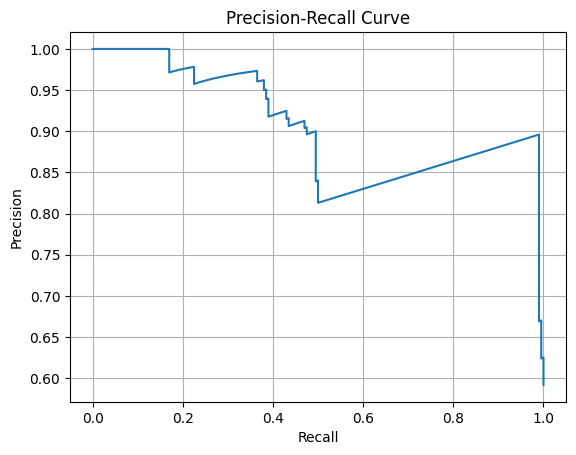

In [ ]:
# ✅ evaluate_chunks.py — Mean-Softmax, Max-Prob Aggregation, Threshold Tuning
import json, torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# -----------------------------
SEED = 42
MAX_LEN = 512
STRIDE = 128
MAX_CHUNKS_PER_DOC = 7
AGG_METHOD = "mean_softmax"  # or "max_prob"

np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load Data + Tokenizer + Model
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw["data"] if isinstance(raw, dict) else raw

LABEL_MAP = {"non_fraud": 0, "fraud": 1}
INV_LABEL = {0: "non_fraud", 1: "fraud"}

model = AutoModelForSequenceClassification.from_pretrained("./deberta-mdna-transfer").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("./deberta-mdna-transfer")
model.eval()

# -----------------------------
def chunk_text(text):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        chunk = tokens[i:i+MAX_LEN]
        chunk += [tokenizer.pad_token_id] * (MAX_LEN - len(chunk))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in chunk]
        chunks.append((chunk, mask))
        i += STRIDE
    return chunks

def aggregate(logits_list, method="mean_softmax"):
    logits = torch.stack(logits_list)
    probs = torch.softmax(logits, dim=-1)
    if method == "mean_softmax":
        return probs.mean(dim=0)
    elif method == "max_prob":
        max_idx = probs[:, 1].argmax()
        return probs[max_idx]
    else:
        raise ValueError("Unknown aggregation method.")

# -----------------------------
# Predict document-level labels
all_labels, all_probs = [], []
for rec in tqdm(raw, desc="Evaluating..."):
    label_str = rec.get("label", rec.get("true_label", rec.get("Label", "")))
    label_cleaned = str(label_str).strip().lower().replace(" ", "_").replace("-", "_")
    label = LABEL_MAP[label_cleaned]
    chunks = chunk_text(rec["text"])
    chunk_logits = []

    for chunk, mask in chunks:
        inputs = {
            "input_ids": torch.tensor([chunk]).to(DEVICE),
            "attention_mask": torch.tensor([mask]).to(DEVICE)
        }
        with torch.no_grad():
            out = model(**inputs).logits.squeeze()
        chunk_logits.append(out)

    prob = aggregate(chunk_logits, method=AGG_METHOD)
    all_labels.append(label)
    all_probs.append(prob.cpu().numpy())

# -----------------------------
# Tune threshold using PR curve
all_probs_np = np.array(all_probs)
true = np.array(all_labels)
probs_fraud = all_probs_np[:, 1]

prec, rec, thresh = precision_recall_curve(true, probs_fraud)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"\n🏁 Best threshold by F1: {best_thresh:.4f}")
print(f"📈 Precision: {prec[best_idx]:.3f} | Recall: {rec[best_idx]:.3f} | F1: {f1_scores[best_idx]:.3f}")

# -----------------------------
# Report at best threshold
preds = (probs_fraud >= best_thresh).astype(int)

print("\n📊 Classification Report (Tuned Threshold):")
print(classification_report(true, preds, target_names=["non_fraud", "fraud"]))

print("📌 Confusion Matrix:")
print(confusion_matrix(true, preds))

# -----------------------------
# ROC-AUC
roc_auc = roc_auc_score(true, probs_fraud)
print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [ ]:
# ==== Colab: Upload zips -> sample <2001 -> save mdna_sample -> download zip ====
import io
import os
import re
import random
import shutil
import zipfile
import tempfile
from collections import Counter

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# -----------------------
# Config you can tweak
# -----------------------
MAX_PER_CLASS = 200
YEAR_CUTOFF = 2006        # keep strictly < 2001 (i.e., up to 2000)
RANDOM_SEED = 42
CLASSES = ("fraud", "non_fraud")
OUTPUT_DIR = "mdna_sample"

# Filename pattern: capture a 4-digit year that is preceded by an underscore, anywhere.
# Examples matched: "5272_2000.txt", "acme_1998_v2.txt", "abc_1975-anything.TXT"
YEAR_RE = re.compile(r"_(19\d{2}|20\d{2})(?:\D|$)", re.IGNORECASE)

def parse_year_from_filename(name):
    m = YEAR_RE.search(name)     # <-- search, not match
    if not m:
        return None
    return int(m.group(1))

def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

def infer_class_from_path(path_lower):
    # zip internals use forward slashes
    if "/non-fraud/" in path_lower or "/non_fraud/" in path_lower or "/nonfraud/" in path_lower:
        return "non_fraud"
    if "/fraud/" in path_lower:
        return "fraud"
    return None

def infer_class_from_zipname(zip_basename_lower):
    if "non-fraud" in zip_basename_lower or "non_fraud" in zip_basename_lower or "nonfraud" in zip_basename_lower:
        return "non_fraud"
    if "fraud" in zip_basename_lower:
        return "fraud"
    return None

def collect_candidates_from_zip(zippath, tmp_extract_root):
    """
    Extract zip to a dedicated folder and collect eligible files per class.
    Returns: { 'fraud': [abs_paths...], 'non_fraud': [...] }
    """
    buckets = {c: [] for c in CLASSES}
    base_name = os.path.splitext(os.path.basename(zippath))[0]
    extract_here = os.path.join(tmp_extract_root, base_name)
    ensure_dir(extract_here)

    with zipfile.ZipFile(zippath, "r") as zf:
        zf.extractall(extract_here)

    # Fallback class from the zip filename (handles zips like 'Fraud_MDA-...zip')
    zip_class_hint = infer_class_from_zipname(os.path.basename(zippath).lower())

    for root, _, files_in_dir in os.walk(extract_here):
        root_lower = root.lower()
        # Prefer internal path hint; else use zip name hint
        cls_hint = infer_class_from_path(root_lower) or zip_class_hint

        for fn in files_in_dir:
            if not fn.lower().endswith(".txt"):
                continue
            year = parse_year_from_filename(fn)
            if year is None or year < YEAR_CUTOFF:
                continue

            full = os.path.join(root, fn)
            # Light read to ensure file is accessible
            try:
                with io.open(full, "r", encoding="utf-8", errors="ignore") as f:
                    _ = f.read(512)
            except Exception:
                continue

            if cls_hint in buckets:
                buckets[cls_hint].append(full)
            # If we still can't infer class, we skip (we only want labeled classes)

    return buckets

def sample_and_copy(files, dst_dir):
    random.seed(RANDOM_SEED)
    if len(files) > MAX_PER_CLASS:
        files = random.sample(files, MAX_PER_CLASS)

    ensure_dir(dst_dir)
    used = set()
    copied = 0
    for src in files:
        name = os.path.basename(src)
        dest = os.path.join(dst_dir, name)
        # Avoid collisions
        if name in used or os.path.exists(dest):
            stem, ext = os.path.splitext(name)
            i = 1
            while True:
                alt = f"{stem}__dup{i}{ext}"
                dest = os.path.join(dst_dir, alt)
                if not os.path.exists(dest):
                    name = alt
                    break
                i += 1
        used.add(name)
        shutil.copy2(src, dest)
        copied += 1
    return copied

def by_year_counts(folder):
    """Return Counter of years for files in folder based on filename."""
    cnt = Counter()
    if not os.path.isdir(folder):
        return cnt
    for fn in os.listdir(folder):
        y = parse_year_from_filename(fn)
        if y is not None:
            cnt[y] += 1
    return cnt

def zip_dir(dir_path, zip_path):
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files_in_dir in os.walk(dir_path):
            for fn in files_in_dir:
                abs_p = os.path.join(root, fn)
                rel_p = os.path.relpath(abs_p, dir_path)
                zf.write(abs_p, rel_p)

# =======================
# Step 1: Upload ZIPs
# =======================
uploaded_paths = []
if IN_COLAB:
    print("📤 Upload one or more ZIP files...")
    uploaded = files.upload()  # user selects zips from laptop
    for name, data in uploaded.items():
        with open(name, "wb") as f:
            f.write(data)
        uploaded_paths.append(os.path.abspath(name))
    if not uploaded_paths:
        raise SystemExit("No files uploaded.")
else:
    raise SystemExit("This notebook cell is intended for Google Colab (files.upload).")

# =======================
# Step 2: Process ZIPs
# =======================
# Clean any previous output
if os.path.isdir(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
ensure_dir(os.path.join(OUTPUT_DIR, "fraud"))
ensure_dir(os.path.join(OUTPUT_DIR, "non_fraud"))

totals = {c: [] for c in CLASSES}

with tempfile.TemporaryDirectory() as tmp_root:
    for zp in uploaded_paths:
        try:
            buckets = collect_candidates_from_zip(zp, tmp_root)
        except Exception as e:
            print(f"[WARN] Failed to handle {os.path.basename(zp)}: {e}")
            continue
        for c in CLASSES:
            totals[c].extend(buckets.get(c, []))

    # Deduplicate (within this run) and sample+copy
    for c in CLASSES:
        unique_files = list(dict.fromkeys(totals[c]))  # preserve order, remove dups
        copied = sample_and_copy(unique_files, os.path.join(OUTPUT_DIR, c))
        print(f"{c:>10}: eligible={len(unique_files):4d}, copied={copied:3d} (max {MAX_PER_CLASS})")

print("\n✅ Done sampling. Saved to:", os.path.abspath(OUTPUT_DIR))

# =======================
# Step 3: By-year counts
# =======================
for c in CLASSES:
    cnt = by_year_counts(os.path.join(OUTPUT_DIR, c))
    if cnt:
        print(f"\n📅 By-year counts for '{c}' (in sample):")
        for y in sorted(cnt):
            print(f"  {y}: {cnt[y]}")
    else:
        print(f"\n📅 By-year counts for '{c}': (no files)")

# =======================
# Step 4: Downloadable ZIP
# =======================
zip_name = "mdna_sample.zip"
zip_dir(OUTPUT_DIR, zip_name)
print("\n📦 Created archive:", os.path.abspath(zip_name))

if IN_COLAB:
    files.download(zip_name)


📤 Upload one or more ZIP files...


Saving Fraud_MDA_cleaned.zip to Fraud_MDA_cleaned (1).zip
Saving Non-fraud_MDA_cleaned.zip to Non-fraud_MDA_cleaned (1).zip
     fraud: eligible= 218, copied=200 (max 200)
 non_fraud: eligible= 728, copied=200 (max 200)

✅ Done sampling. Saved to: /content/mdna_sample

📅 By-year counts for 'fraud' (in sample):
  2006: 13
  2007: 15
  2008: 12
  2009: 33
  2010: 31
  2011: 25
  2012: 20
  2013: 14
  2014: 8
  2015: 10
  2016: 9
  2017: 8
  2018: 2

📅 By-year counts for 'non_fraud' (in sample):
  2006: 12
  2007: 13
  2008: 22
  2009: 18
  2010: 20
  2011: 19
  2012: 10
  2013: 15
  2014: 9
  2015: 11
  2016: 12
  2017: 11
  2018: 14
  2019: 14

📦 Created archive: /content/mdna_sample.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === Build mdna_samples.json from mdna_sample.zip ===
import os, io, json, zipfile, shutil

ZIP_NAME = "mdna_sample.zip"         # <-- must exist in current working dir
EXTRACT_DIR = "./mdna_sample_extracted"
OUTPUT_JSON = "mdna_samples.json"

# 1) Ensure the zip exists (if not, let you upload it)
if not os.path.isfile(ZIP_NAME):
    try:
        from google.colab import files
        print(f"⚠️ {ZIP_NAME} not found. Please upload it now.")
        uploaded = files.upload()
        if ZIP_NAME not in uploaded:
            raise FileNotFoundError(f"'{ZIP_NAME}' was not uploaded.")
    except Exception as e:
        raise FileNotFoundError(f"{ZIP_NAME} not found and upload failed: {e}")

# 2) Fresh extract
if os.path.isdir(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, "r") as zf:
    zf.extractall(EXTRACT_DIR)

# 3) Walk extracted folders -> collect .txt into JSON
samples = []
per_class_counts = {"fraud": 0, "non_fraud": 0, "unknown": 0}

def infer_class_from_path(p: str):
    p = p.replace("\\", "/").lower()
    if "/non_fraud/" in p or "/non-fraud/" in p or "/nonfraud/" in p:
        return "non_fraud"
    if "/fraud/" in p:
        return "fraud"
    # If structure is mdna_sample/<class>/..., handle that too
    parts = p.split("/")
    for name in ("fraud", "non_fraud", "non-fraud", "nonfraud"):
        if name in parts:
            return "non_fraud" if "non" in name else "fraud"
    return "unknown"

for root, _, files_in_dir in os.walk(EXTRACT_DIR):
    for fn in files_in_dir:
        if not fn.lower().endswith(".txt"):
            continue
        fpath = os.path.join(root, fn)
        cls = infer_class_from_path(fpath)
        try:
            with io.open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read().strip()
        except Exception:
            continue
        if not text:
            continue
        label = "Fraud" if cls == "fraud" else ("Non-Fraud" if cls == "non_fraud" else None)
        if label is None:
            per_class_counts["unknown"] += 1
            continue
        samples.append({"text": text, "true_label": label})
        per_class_counts[cls] += 1

# 4) Save JSON
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(samples, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {OUTPUT_JSON} with {len(samples)} samples.")
print("Counts:", per_class_counts)

# (Optional) peek a couple of records
for i, s in enumerate(samples[:2]):
    print(f"\nSample {i+1}: label={s['true_label']}\n{text[:200]}...")


✅ Saved mdna_samples.json with 400 samples.
Counts: {'fraud': 200, 'non_fraud': 200, 'unknown': 0}

Sample 1: label=Fraud
ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS TopicPageOverview 29Financial Summary 32Critical Accounting Estimates 32Accounting Standards 40Consolidate...

Sample 2: label=Fraud
ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS TopicPageOverview 29Financial Summary 32Critical Accounting Estimates 32Accounting Standards 40Consolidate...


In [ ]:
import json
from collections import Counter

# ---------- 1) Load JSON (array or dict wrapper) ----------
with open("mdna_samples.json", "r") as f:
    raw = json.load(f)

# If file is a dict wrapper, pick the first list-like field
if isinstance(raw, dict):
    # common wrappers
    for k in ["data", "records", "items", "rows", "samples"]:
        if k in raw and isinstance(raw[k], list):
            raw = raw[k]
            break
    # if still dict, try any list value
    if isinstance(raw, dict):
        for v in raw.values():
            if isinstance(v, list):
                raw = v
                break

if not isinstance(raw, list):
    raise ValueError("Expected a list of records in mdna_samples.json")

# ---------- 2) Helpers to find label/text in messy schemas ----------
CANDIDATE_LABEL_FIELDS = ["label","Label","true_label","target","class","Class","y","tag"]
CANDIDATE_TEXT_FIELDS  = ["text","Text","content","document","body","mdna","mdna_text","md&a","mdna_body"]

def find_field(rec, names):
    for n in names:
        if n in rec:
            return rec[n]
    # one-level nested search
    for v in rec.values():
        if isinstance(v, dict):
            for n in names:
                if n in v:
                    return v[n]
    return None

def normalize_label(val):
    if val is None: return "unknown"
    s = str(val).strip().lower()
    # unify common variants
    s = s.replace("-", "_").replace(" ", "_")
    if s in {"nonfraud","non_fraud","not_fraud","clean"}:
        return "non_fraud"
    if s in {"fraud","is_fraud","positive"}:
        return "fraud"
    if s in {"unknown","na","", "null", "none"}:
        return "unknown"
    # last resort: if it looks like '0'/'1'
    if s.isdigit():
        return "fraud" if int(s)==1 else "non_fraud" if int(s)==0 else "unknown"
    return s  # keep as-is; we'll validate later

def normalize_text(val):
    if val is None: return None
    s = str(val).strip()
    return s if s else None

# ---------- 3) Build a clean list; map to ints ----------
clean = []
bad_schema = 0
for rec in raw:
    lbl_raw = find_field(rec, CANDIDATE_LABEL_FIELDS)
    txt_raw = find_field(rec, CANDIDATE_TEXT_FIELDS)
    lbl = normalize_label(lbl_raw)
    txt = normalize_text(txt_raw)

    if txt is None:
        bad_schema += 1
        continue

    clean.append({
        "text": txt,
        "label_text": lbl,     # keep human-readable for audit
    })

# Counts BEFORE integer mapping
pre_counts = Counter([r["label_text"] for r in clean])
print("Pre-normalized label counts:", pre_counts, "| dropped text-missing:", bad_schema)

# Only keep fraud/non_fraud; drop unknowns if any
LABEL_MAP = {"non_fraud": 0, "fraud": 1}
final = []
unknown_seen = 0
for r in clean:
    if r["label_text"] in LABEL_MAP:
        r["label"] = LABEL_MAP[r["label_text"]]
        final.append({"text": r["text"], "label": r["label"]})
    else:
        unknown_seen += 1

print("Kept:", len(final), "Unknown/dropped:", unknown_seen)
print("Final counts:", Counter([r["label"] for r in final]))  # expect {1:188, 0:191} for your file

# ---------- 4) Save clean file ----------
with open("mdna_samples_clean.json", "w") as f:
    json.dump(final, f, ensure_ascii=False, indent=2)
print("✅ Saved mdna_samples_clean.json")


Pre-normalized label counts: Counter({'fraud': 200, 'non_fraud': 200}) | dropped text-missing: 0
Kept: 400 Unknown/dropped: 0
Final counts: Counter({1: 200, 0: 200})
✅ Saved mdna_samples_clean.json


In [ ]:
# ✅ mdna_transfer_from_fake_news.py — Enhanced to Improve Non-Fraud Detection Too

import os, json, torch, numpy as np, random, re
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

SEED = 42
MAX_LEN = 512
STRIDE = 128
BATCH_SIZE = 8
EPOCHS = 6
MAX_CHUNKS_PER_DOC = 7
MODEL_PATH = "./deberta-small-fake-news"
SAVE_PATH = "./deberta-mdna-transfer"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 🧪 Set Seeds for Reproducibility
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# 📚 Load and Clean Data
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw.get("data") if isinstance(raw, dict) else raw

CANDIDATE_LABEL_FIELDS = ["label", "Label", "true_label"]
CANDIDATE_TEXT_FIELDS = ["text", "Text", "content", "document"]
LABEL_MAP = {"non_fraud": 0, "fraud": 1}

cleaned = []
for rec in raw:
    text = next((rec.get(f) for f in CANDIDATE_TEXT_FIELDS if rec.get(f)), None)
    label_raw = next((rec.get(f) for f in CANDIDATE_LABEL_FIELDS if rec.get(f)), None)
    if not text: continue
    label = str(label_raw).strip().lower().replace(" ", "_")
    label = "fraud" if label in ["fraud", "1"] else "non_fraud"
    cleaned.append({"text": text.strip(), "label": LABEL_MAP[label]})

texts = [r["text"] for r in cleaned]
labels = [r["label"] for r in cleaned]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=SEED
)

# -----------------------------
# ✂️ Tokenize & Chunk Texts

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


def chunk_text(text, label):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        chunk = tokens[i:i+MAX_LEN] + [tokenizer.pad_token_id]*(MAX_LEN - len(tokens[i:i+MAX_LEN]))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in chunk]
        chunks.append((chunk, mask, label))
        i += STRIDE
    return chunks


class ChunkedDataset(Dataset):
    def __init__(self, texts, labels, cache_file):
        if os.path.exists(cache_file):
            self.samples = torch.load(cache_file)
        else:
            with ThreadPoolExecutor() as executor:
                all_chunks = executor.map(lambda x: chunk_text(*x), zip(texts, labels))
                self.samples = [item for sublist in all_chunks for item in sublist]
                torch.save(self.samples, cache_file)

    def __getitem__(self, idx):
        chunk, mask, label = self.samples[idx]
        return {"input_ids": torch.tensor(chunk), "attention_mask": torch.tensor(mask), "labels": torch.tensor(label)}

    def __len__(self): return len(self.samples)

train_dataset = ChunkedDataset(train_texts, train_labels, "train_chunks.pt")
val_dataset = ChunkedDataset(val_texts, val_labels, "val_chunks.pt")

# -----------------------------
# 🧠 Load Model & Partially Unfreeze Last 6 Layers
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(DEVICE)

for name, param in model.named_parameters():
    match = re.search(r'encoder\\.layer\\.(\\d+)', name)
    if match:
        layer = int(match.group(1))
        if layer < model.config.num_hidden_layers - 6:
            param.requires_grad = False

# -----------------------------
# 📊 Class Weighting (Balanced)
weights = compute_class_weight("balanced", classes=np.unique(labels), y=np.array(labels))
class_weights = torch.tensor(weights).float().to(DEVICE)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.CrossEntropyLoss(weight=class_weights)(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

# -----------------------------
# 🧪 Metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# -----------------------------
# ⚙️ Training Arguments
args = TrainingArguments(
    output_dir=SAVE_PATH,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    gradient_accumulation_steps=2,
    dataloader_num_workers=2,
    max_grad_norm=1.0
)

# -----------------------------
# 🏋️‍♀️ Train
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print("✅ Training complete and model saved.")


/tmp/ipython-input-3178380519.py:158: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.653920,0.637500,0.639610,0.975248,0.772549
2,1.409800,0.639887,0.690625,0.719149,0.836634,0.773455
3,1.409800,0.709177,0.693750,0.726087,0.826733,0.773148
4,0.446000,0.975427,0.693750,0.728070,0.821782,0.772093


✅ Training complete and model saved.


Evaluating...: 100%|██████████| 400/400 [00:44<00:00,  8.98it/s]


🏁 Best threshold by F1: 0.6402
📈 Precision: 0.848 | Recall: 0.670 | F1: 0.749

📊 Classification Report (Tuned Threshold):
              precision    recall  f1-score   support

   non_fraud       0.73      0.88      0.80       200
       fraud       0.85      0.67      0.75       200

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.77       400
weighted avg       0.79      0.78      0.77       400

📌 Confusion Matrix:
[[176  24]
 [ 66 134]]
🎯 ROC-AUC Score: 0.6810


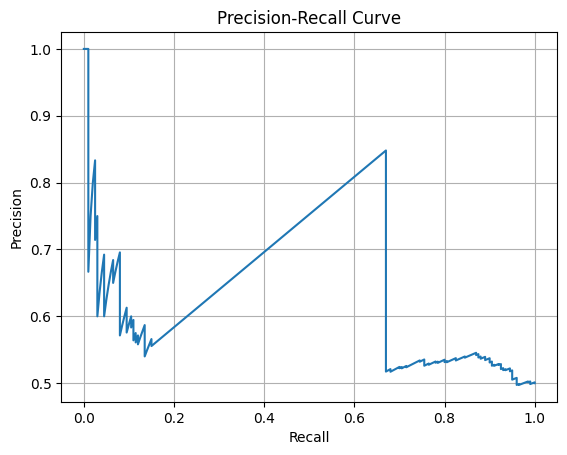

In [ ]:
# ✅ evaluate_chunks.py — Mean-Softmax, Max-Prob Aggregation, Threshold Tuning
import json, torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# -----------------------------
SEED = 42
MAX_LEN = 512
STRIDE = 128
MAX_CHUNKS_PER_DOC = 7
AGG_METHOD = "mean_softmax"  # or "max_prob"

np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load Data + Tokenizer + Model
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw["data"] if isinstance(raw, dict) else raw

LABEL_MAP = {"non_fraud": 0, "fraud": 1}
INV_LABEL = {0: "non_fraud", 1: "fraud"}

model = AutoModelForSequenceClassification.from_pretrained("./deberta-mdna-transfer").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("./deberta-mdna-transfer")
model.eval()

# -----------------------------
def chunk_text(text):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        chunk = tokens[i:i+MAX_LEN]
        chunk += [tokenizer.pad_token_id] * (MAX_LEN - len(chunk))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in chunk]
        chunks.append((chunk, mask))
        i += STRIDE
    return chunks

def aggregate(logits_list, method="mean_softmax"):
    logits = torch.stack(logits_list)
    probs = torch.softmax(logits, dim=-1)
    if method == "mean_softmax":
        return probs.mean(dim=0)
    elif method == "max_prob":
        max_idx = probs[:, 1].argmax()
        return probs[max_idx]
    else:
        raise ValueError("Unknown aggregation method.")

# -----------------------------
# Predict document-level labels
all_labels, all_probs = [], []
for rec in tqdm(raw, desc="Evaluating..."):
    label_str = rec.get("label", rec.get("true_label", rec.get("Label", "")))
    label_cleaned = str(label_str).strip().lower().replace(" ", "_").replace("-", "_")
    label = LABEL_MAP[label_cleaned]
    chunks = chunk_text(rec["text"])
    chunk_logits = []

    for chunk, mask in chunks:
        inputs = {
            "input_ids": torch.tensor([chunk]).to(DEVICE),
            "attention_mask": torch.tensor([mask]).to(DEVICE)
        }
        with torch.no_grad():
            out = model(**inputs).logits.squeeze()
        chunk_logits.append(out)

    prob = aggregate(chunk_logits, method=AGG_METHOD)
    all_labels.append(label)
    all_probs.append(prob.cpu().numpy())

# -----------------------------
# Tune threshold using PR curve
all_probs_np = np.array(all_probs)
true = np.array(all_labels)
probs_fraud = all_probs_np[:, 1]

prec, rec, thresh = precision_recall_curve(true, probs_fraud)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"\n🏁 Best threshold by F1: {best_thresh:.4f}")
print(f"📈 Precision: {prec[best_idx]:.3f} | Recall: {rec[best_idx]:.3f} | F1: {f1_scores[best_idx]:.3f}")

# -----------------------------
# Report at best threshold
preds = (probs_fraud >= best_thresh).astype(int)

print("\n📊 Classification Report (Tuned Threshold):")
print(classification_report(true, preds, target_names=["non_fraud", "fraud"]))

print("📌 Confusion Matrix:")
print(confusion_matrix(true, preds))

# -----------------------------
# ROC-AUC
roc_auc = roc_auc_score(true, probs_fraud)
print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [ ]:
# ✅ mdna_transfer_from_fake_news.py — Enhanced to Improve Non-Fraud Detection Too
# - Fixes Trainer API change (num_items_in_batch kwarg)
# - Replaces deprecated `tokenizer=` with `processing_class=tokenizer`
# - Uses Focal Loss + balanced chunk sampler to lift fraud recall

import os, json, torch, numpy as np, random, re
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# ⚙️ Config
SEED = 42
MAX_LEN = 512
STRIDE = 128
BATCH_SIZE = 8
EPOCHS = 6
MAX_CHUNKS_PER_DOC = 7
MODEL_PATH = "./deberta-small-fake-news"
SAVE_PATH = "./deberta-mdna-transfer"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNFREEZE_LAST_K = 6  # keep your original behavior

# -----------------------------
# 🧪 Reproducibility
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# 📚 Load and Clean Data
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw.get("data") if isinstance(raw, dict) else raw

CANDIDATE_LABEL_FIELDS = ["label", "Label", "true_label"]
CANDIDATE_TEXT_FIELDS = ["text", "Text", "content", "document"]
LABEL_MAP = {"non_fraud": 0, "fraud": 1}

cleaned = []
for rec in raw:
    text = next((rec.get(f) for f in CANDIDATE_TEXT_FIELDS if rec.get(f)), None)
    label_raw = next((rec.get(f) for f in CANDIDATE_LABEL_FIELDS if rec.get(f) is not None), None)
    if not text:
        continue
    label_norm = str(label_raw).strip().lower().replace(" ", "_") if label_raw is not None else "non_fraud"
    label_str = "fraud" if label_norm in ["fraud", "1", "true", "yes"] else "non_fraud"
    cleaned.append({"text": text.strip(), "label": LABEL_MAP[label_str]})

texts = [r["text"] for r in cleaned]
labels = [r["label"] for r in cleaned]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=SEED
)

# -----------------------------
# ✂️ Tokenize & Chunk Texts
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, use_fast=True)

def chunk_text(text, label):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        window = tokens[i:i + MAX_LEN]
        if len(window) < MAX_LEN:
            window = window + [tokenizer.pad_token_id] * (MAX_LEN - len(window))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in window]
        chunks.append((window, mask, label))
        i += STRIDE
    return chunks

class ChunkedDataset(Dataset):
    def __init__(self, texts, labels, cache_file):
        if os.path.exists(cache_file):
            self.samples = torch.load(cache_file)
        else:
            with ThreadPoolExecutor() as executor:
                all_chunks = executor.map(lambda x: chunk_text(*x), zip(texts, labels))
                self.samples = [item for sublist in all_chunks for item in sublist]
            torch.save(self.samples, cache_file)

    def __getitem__(self, idx):
        chunk, mask, label = self.samples[idx]
        return {
            "input_ids": torch.tensor(chunk, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.samples)

train_dataset = ChunkedDataset(train_texts, train_labels, "train_chunks.pt")
val_dataset   = ChunkedDataset(val_texts,   val_labels,   "val_chunks.pt")

# -----------------------------
# 🧠 Load Model & Partially Unfreeze Last K Layers
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2).to(DEVICE)

for name, param in model.named_parameters():
    m = re.search(r'encoder\.layer\.(\d+)', name)
    if m:
        layer_idx = int(m.group(1))
        if layer_idx < model.config.num_hidden_layers - UNFREEZE_LAST_K:
            param.requires_grad = False

# -----------------------------
# 📊 Class Weights (TRAIN only)
class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=np.array(train_labels)
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(DEVICE)

# -----------------------------
# 🔥 Focal Loss + Weighted Trainer (improves minority recall)
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=1.5, reduction="mean"):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.ce = torch.nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, logits, target):
        ce = self.ce(logits, target)  # [B]
        with torch.no_grad():
            pt = torch.softmax(logits, dim=-1).gather(1, target.unsqueeze(1)).squeeze(1).clamp_min(1e-6)
        focal = (1.0 - pt) ** self.gamma * ce
        return focal.mean() if self.reduction == "mean" else focal.sum()

class WeightedFocalTrainer(Trainer):
    def __init__(self, *args, class_weights=None, gamma=1.5, sampler=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.focal = FocalLoss(weight=class_weights, gamma=gamma)
        self._sampler = sampler

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # accept extra kwargs (e.g., num_items_in_batch) from newer HF Trainer
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = self.focal(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

    # Use balanced sampling at the CHUNK level for training
    def get_train_dataloader(self):
        if self._sampler is None:
            return super().get_train_dataloader()
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=self._sampler,
            collate_fn=self.data_collator,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=True
        )

# -----------------------------
# 🧪 Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall":    recall_score(labels, preds),
        "f1":        f1_score(labels, preds)
    }

# -----------------------------
# 🧮 Balanced CHUNK sampler (helps minority recall)
y_train_chunks = np.array([lbl for _, _, lbl in train_dataset.samples])
class_sample_counts = np.bincount(y_train_chunks, minlength=2).astype(np.float32)
# inverse-frequency weights per class
weights_per_class = class_sample_counts.sum() / (2.0 * np.clip(class_sample_counts, 1, None))
sample_weights = weights_per_class[y_train_chunks]
sampler = WeightedRandomSampler(weights=sample_weights.tolist(),
                                num_samples=len(sample_weights),
                                replacement=True)

# -----------------------------
# ⚙️ Training Arguments
args = TrainingArguments(
    output_dir=SAVE_PATH,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    seed=SEED,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    gradient_accumulation_steps=2,
    dataloader_num_workers=2,
    max_grad_norm=1.0
)

data_collator = DataCollatorWithPadding(tokenizer)

# -----------------------------
# 🏋️‍♀️ Train
trainer = WeightedFocalTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,  # <-- replaces deprecated `tokenizer=`
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    class_weights=class_weights,
    gamma=1.5,
    sampler=sampler
)

trainer.train()

# -----------------------------
# 💾 Save
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print("✅ Training complete and model saved at:", os.path.abspath(SAVE_PATH))


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.326583,0.365625,0.487179,0.094059,0.157676
2,1.030600,0.272891,0.571875,0.701863,0.559406,0.622590
3,1.030600,0.353981,0.662500,0.715596,0.772277,0.742857
4,0.177600,0.436334,0.734375,0.782609,0.801980,0.792176
5,0.087400,0.480107,0.712500,0.766990,0.782178,0.774510
6,0.087400,0.522352,0.718750,0.764151,0.801980,0.782609


✅ Training complete and model saved at: /content/deberta-mdna-transfer


In [ ]:
# ✅ evaluate_chunks.py — Val/Test split • Top-K aggregation • F1/F2 thresholding • Saved artifacts
import os, json, re, torch, numpy as np
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt

# -----------------------------
SEED = 42
MAX_LEN = 512
STRIDE = 128
MAX_CHUNKS_PER_DOC = 10      # a little higher recall than 7
AGG_METHOD = "topk_mean"     # "mean_softmax" | "max_prob" | "topk_mean"
TOPK = 3                     # used if AGG_METHOD == "topk_mean"
MODEL_DIR = "./deberta-mdna-transfer"
OUT_DIR = "./eval_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load Data (+ normalize fields)
with open("mdna_samples.json") as f:
    raw = json.load(f)
    raw = raw["data"] if isinstance(raw, dict) else raw

CANDIDATE_LABEL_FIELDS = ["label", "Label", "true_label"]
CANDIDATE_TEXT_FIELDS = ["text", "Text", "content", "document"]
LABEL_MAP = {"non_fraud": 0, "fraud": 1}

docs = []
for i, rec in enumerate(raw):
    text = next((rec.get(k) for k in CANDIDATE_TEXT_FIELDS if rec.get(k)), None)
    if not text:
        continue
    lab_raw = next((rec.get(k) for k in CANDIDATE_LABEL_FIELDS if rec.get(k) is not None), "non_fraud")
    lab_norm = str(lab_raw).strip().lower().replace(" ", "_").replace("-", "_")
    lab_str = "fraud" if lab_norm in ["fraud", "1", "true", "yes"] else "non_fraud"
    docs.append({"id": i, "text": text.strip(), "label": LABEL_MAP[lab_str]})

texts = [d["text"] for d in docs]
labels = [d["label"] for d in docs]

# -----------------------------
# Val/Test split (NOTE: may overlap with training docs if you didn't persist IDs)
X_tmp, X_test, y_tmp, y_test, id_tmp, id_test = train_test_split(
    texts, labels, [d["id"] for d in docs],
    test_size=0.25, stratify=labels, random_state=SEED
)
X_val, X_hold, y_val, y_hold, id_val, id_hold = train_test_split(
    X_tmp, y_tmp, id_tmp, test_size=0.3333, stratify=y_tmp, random_state=SEED
)
# Now: ~25% val (X_val), ~25% test (X_test). We ignore X_hold.

# -----------------------------
# Model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

def chunk_text(text):
    tokens = tokenizer(text, truncation=False)["input_ids"]
    chunks, i = [], 0
    while i < len(tokens) and len(chunks) < MAX_CHUNKS_PER_DOC:
        window = tokens[i:i + MAX_LEN]
        if len(window) < MAX_LEN:
            window = window + [tokenizer.pad_token_id] * (MAX_LEN - len(window))
        mask = [1 if t != tokenizer.pad_token_id else 0 for t in window]
        chunks.append((window, mask))
        i += STRIDE
    return chunks

def aggregate(logits_list, method=AGG_METHOD, topk=TOPK):
    L = torch.stack(logits_list)                   # [num_chunks, 2]
    P = torch.softmax(L, dim=-1)                   # probs
    if method == "mean_softmax":
        return P.mean(dim=0)                       # [2]
    if method == "max_prob":
        idx = torch.argmax(P[:, 1])
        return P[idx]                              # [2]
    if method == "topk_mean":
        k = min(topk, P.shape[0])
        vals, _ = torch.topk(P[:, 1], k)
        p1 = vals.mean()
        return torch.tensor([1 - p1, p1], device=P.device)
    raise ValueError("Unknown aggregation method")

@torch.no_grad()
def infer_probs(texts):
    probs = []
    for t in tqdm(texts, desc="Infer"):
        logits_list = []
        for chunk, mask in chunk_text(t):
            inputs = {
                "input_ids": torch.tensor([chunk], dtype=torch.long, device=DEVICE),
                "attention_mask": torch.tensor([mask], dtype=torch.long, device=DEVICE),
            }
            out = model(**inputs).logits.squeeze(0)   # [2]
            logits_list.append(out)
        if len(logits_list) == 0:
            # empty text edge-case: predict non-fraud lightly
            probs.append(np.array([0.55, 0.45], dtype=np.float32))
        else:
            p = aggregate(logits_list)
            probs.append(p.detach().cpu().numpy())
    return np.vstack(probs)   # [N, 2]

# -----------------------------
# 1) Inference on VAL (for threshold tuning)
val_probs = infer_probs(X_val)             # [N_val, 2]
val_true  = np.array(y_val, dtype=int)
val_p1    = val_probs[:, 1]

# F1 threshold
prec, rec, thr = precision_recall_curve(val_true, val_p1)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
i1 = int(np.nanargmax(f1))
t_f1 = float(thr[max(i1, 0)])
print(f"\n🏁 Best F1 threshold: {t_f1:.4f} | P={prec[i1]:.3f} R={rec[i1]:.3f} F1={f1[i1]:.3f}")

# F2 threshold (recall-leaning)
beta = 2.0
f2 = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-8)
i2 = int(np.nanargmax(f2))
t_f2 = float(thr[max(i2, 0)])
print(f"🏁 Best F2 threshold: {t_f2:.4f} | P={prec[i2]:.3f} R={rec[i2]:.3f} F2={f2[i2]:.3f}")

# Pick which threshold to use downstream:
BEST_T = t_f2   # prefer higher recall; change to t_f1 if you prefer balance
np.savez(os.path.join(OUT_DIR, "val_thresholds.npz"), t_f1=t_f1, t_f2=t_f2)

# -----------------------------
# 2) Inference on TEST (report only)
test_probs = infer_probs(X_test)
test_true  = np.array(y_test, dtype=int)
test_p1    = test_probs[:, 1]
test_pred  = (test_p1 >= BEST_T).astype(int)

print("\n📊 Classification Report (TEST @ tuned threshold):")
print(classification_report(test_true, test_pred, target_names=["non_fraud", "fraud"], digits=3))

print("📌 Confusion Matrix (TEST):")
print(confusion_matrix(test_true, test_pred))

roc = roc_auc_score(test_true, test_p1)
pr_auc = average_precision_score(test_true, test_p1)  # PR-AUC (fraud=positive)
print(f"🎯 ROC-AUC (TEST): {roc:.4f} | PR-AUC: {pr_auc:.4f}")

# -----------------------------
# 3) Save artifacts
np.savez(
    os.path.join(OUT_DIR, "test_doc_level_probs.npz"),
    probs=test_probs, labels=test_true, ids=np.array(id_test)
)

# PR curve figure
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve (val) — method={AGG_METHOD}, topk={TOPK}")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"pr_curve_val_{AGG_METHOD}_k{TOPK}.png"), dpi=160)
plt.close()

# Calibration-ish histogram
plt.figure()
plt.hist(test_p1[test_true==1], bins=20, alpha=0.6, label="fraud")
plt.hist(test_p1[test_true==0], bins=20, alpha=0.6, label="non_fraud")
plt.xlabel("Predicted P(fraud)"); plt.ylabel("Count")
plt.title("Score distribution (TEST)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "score_hist_test.png"), dpi=160)
plt.close()

print(f"\n🗂 Saved artifacts in: {os.path.abspath(OUT_DIR)}")
print(f"   - val_thresholds.npz (t_f1, t_f2)")
print(f"   - test_doc_level_probs.npz (probs, labels, ids)")
print(f"   - pr_curve_val_{AGG_METHOD}_k{TOPK}.png")
print(f"   - score_hist_test.png")


Infer: 100%|██████████| 200/200 [00:25<00:00,  7.74it/s]



🏁 Best F1 threshold: 0.5376 | P=0.795 R=0.890 F1=0.840
🏁 Best F2 threshold: 0.5376 | P=0.795 R=0.890 F2=0.869


Infer: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]



📊 Classification Report (TEST @ tuned threshold):
              precision    recall  f1-score   support

   non_fraud      0.905     0.760     0.826        50
       fraud      0.793     0.920     0.852        50

    accuracy                          0.840       100
   macro avg      0.849     0.840     0.839       100
weighted avg      0.849     0.840     0.839       100

📌 Confusion Matrix (TEST):
[[38 12]
 [ 4 46]]
🎯 ROC-AUC (TEST): 0.7732 | PR-AUC: 0.7482

🗂 Saved artifacts in: /content/eval_artifacts
   - val_thresholds.npz (t_f1, t_f2)
   - test_doc_level_probs.npz (probs, labels, ids)
   - pr_curve_val_topk_mean_k3.png
   - score_hist_test.png
